In [1]:
import kagglehub

path = kagglehub.dataset_download("ishanikathuria/handwritten-signature-datasets")

print("Path to dataset files:", path)

100%|██████████| 290M/290M [00:02<00:00, 123MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ishanikathuria/handwritten-signature-datasets/versions/3


In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Lambda
from skimage import morphology

In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy()

print("Number of accelerators: ", strategy.num_replicas_in_sync)

Number of accelerators:  8


In [4]:
bengali_directory = os.path.join(path, 'BHSig260-Bengali/BHSig260-Bengali')
hindi_directory = os.path.join(path, 'BHSig260-Hindi/BHSig260-Hindi')
cedar_directory = os.path.join(path, 'CEDAR/CEDAR')

In [5]:
def deskew(image):
    """Correct image skew using minimum area rectangle"""
    coords = np.column_stack(np.where(image > 0))
    if len(coords) < 5:  # Insufficient points for rotation calculation
        return image

    rect = cv2.minAreaRect(coords)
    angle = rect[-1]

    # Adjust angle convention
    angle = -angle if angle < -45 else -(90 + angle)

    # Rotate image
    h, w = image.shape[:2]
    center = (w//2, h//2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    return cv2.warpAffine(image, M, (w, h),
                        flags=cv2.INTER_LINEAR,
                        borderMode=cv2.BORDER_CONSTANT,
                        borderValue=0)

In [6]:
def preprocess_image(image_path, target_size=(224, 224)):
    """Process image into multi-channel CNN input with feature-enhanced channels"""
    # Read and convert to grayscale
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Image not found at {image_path}")
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Resize first to target dimensions
    resized = cv2.resize(gray, target_size)

    # Noise reduction (Median Filter)
    denoised = cv2.medianBlur(resized, 3)

    # Contrast Limited Adaptive Histogram Equalization (CLAHE)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    contrast_enhanced = clahe.apply(denoised)

    # Binarization with Otsu's thresholding
    _, binary = cv2.threshold(contrast_enhanced, 0, 255,
                            cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Deskew using binary image
    deskewed = deskew(binary)

    # Morphological processing
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    morph = cv2.morphologyEx(deskewed, cv2.MORPH_CLOSE, kernel)
    morph = cv2.morphologyEx(morph, cv2.MORPH_OPEN, kernel)

    # Skeletonization
    skeleton = morphology.skeletonize(morph.astype(bool))
    skeleton = skeleton.astype(np.uint8) * 255

    # Edge detection (Canny)
    edges = cv2.Canny(morph, 80, 160)

    # Create multi-channel image
    channels = [
        morph,        # Channel 1: Cleaned binary
        edges,        # Channel 2: Edge features
        skeleton      # Channel 3: Structural skeleton
    ]

    # Normalize and combine channels
    processed = np.stack([(c/255.0).astype(np.float32) for c in channels], axis=-1)

    return processed

In [7]:
def load_dataset(dataset_path):
    """Load and prepare dataset for training with robust error handling"""
    if not os.path.exists(dataset_path):
        raise FileNotFoundError(f"Dataset path not found: {dataset_path}")

    person_dirs = [d for d in os.listdir(dataset_path)
                  if os.path.isdir(os.path.join(dataset_path, d))]

    if not person_dirs:
        raise ValueError(f"No person directories found in {dataset_path}")

    person_dirs = sorted(person_dirs)

    pairs = []
    labels = []

    for person_dir in person_dirs:
        full_path = os.path.join(dataset_path, person_dir)

        image_files = os.listdir(full_path)
        genuine_files = [f for f in image_files if 'G' in f or 'original' in f]
        forged_files = [f for f in image_files if 'F' in f or 'forgeries' in f]

        if not genuine_files or not forged_files:
            print(f"Warning: Missing genuine or forged files for {person_dir}")
            continue
        for i in range(len(genuine_files)):
            for j in range(i + 1, len(genuine_files)):
                try:
                    anchor = preprocess_image(os.path.join(full_path, genuine_files[i]))
                    positive = preprocess_image(os.path.join(full_path, genuine_files[j]))
                    pairs.append([anchor, positive])
                    labels.append(1)
                except Exception as e:
                    print(f"Error processing positive pair: {e}")
                    continue

        for i in range(min(len(genuine_files), len(forged_files))):
            try:
                anchor = preprocess_image(os.path.join(full_path, genuine_files[i]))
                negative = preprocess_image(os.path.join(full_path, forged_files[i]))
                pairs.append([anchor, negative])
                labels.append(0)
            except Exception as e:
                print(f"Error processing negative pair: {e}")
                continue

    if not pairs:
        raise ValueError(f"No valid pairs could be created from {dataset_path}")

    pairs = np.array(pairs)
    labels = np.array(labels)

    train_pairs, test_pairs, train_labels, test_labels = train_test_split(
        pairs, labels, test_size=0.2, random_state=42
    )

    train_pairs, val_pairs, train_labels, val_labels = train_test_split(
        train_pairs, train_labels, test_size=0.2, random_state=42
    )

    return (train_pairs, train_labels), (val_pairs, val_labels), (test_pairs, test_labels)

In [8]:
def euclidean_distance(vectors):
    x, y = vectors
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

In [9]:
def contrastive_loss(y_true, y_pred, margin=1.0):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean((1 - y_true) * square_pred + y_true * margin_square)

In [10]:
with strategy.scope():
    # Base VGG16 model
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False

    # Feature extraction model
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    embedding = Dense(128)(x)
    embedding_model = Model(base_model.input, embedding)

    # Siamese network
    input_1 = Input(shape=(224, 224, 3))
    input_2 = Input(shape=(224, 224, 3))

    embedding_1 = embedding_model(input_1)
    embedding_2 = embedding_model(input_2)

    distance = Lambda(euclidean_distance)([embedding_1, embedding_2])
    predictions = Dense(1, activation='sigmoid')(distance)

    siamese_model = Model(inputs=[input_1, input_2], outputs=predictions)

    # Custom optimizer configuration for TPU
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    siamese_model.compile(optimizer=optimizer, metrics=['accuracy'], loss=contrastive_loss)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6
    )
]

In [12]:
(cedar_train_pairs, cedar_train_labels), (cedar_val_pairs, cedar_val_labels), (cedar_test_pairs, cedar_test_labels) = load_dataset(cedar_directory)

In [14]:
batch_size = 128 * strategy.num_replicas_in_sync
batch_size

1024

In [15]:
def create_tf_dataset(pairs, labels):
    anchor_images = pairs[:, 0]
    other_images = pairs[:, 1]
    dataset = tf.data.Dataset.from_tensor_slices(((anchor_images, other_images), labels))
    return dataset.shuffle(1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [16]:
train_dataset = create_tf_dataset(cedar_train_pairs, cedar_train_labels)
val_dataset = create_tf_dataset(cedar_val_pairs, cedar_val_labels)
test_dataset = create_tf_dataset(cedar_test_pairs, cedar_test_labels)

In [17]:
history = siamese_model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    callbacks=callbacks
)

Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 129s 10s/step - accuracy: 0.9277 - loss: 1.8122 - val_accuracy: 0.9242 - val_loss: 1.3993 - learning_rate: 0.0010
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 90s 7s/step - accuracy: 0.9217 - loss: 1.3822 - val_accuracy: 0.9188 - val_loss: 1.0206 - learning_rate: 0.0010
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 89s 7s/step - accuracy: 0.9231 - loss: 0.9497 - val_accuracy: 0.9202 - val_loss: 0.8166 - learning_rate: 0.0010
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 89s 7s/step - accuracy: 0.9223 - loss: 0.7724 - val_accuracy: 0.9222 - val_loss: 0.7125 - learning_rate: 0.0010
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 89s 7s/step - accuracy: 0.9210 - loss: 0.7078 - val_accuracy: 0.9205 - val_loss: 0.6968 - learning_rate: 0.0010
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 90s 7s/step - accuracy: 0.9242 - loss: 0.6554 - val_accuracy: 0.9177 - val_loss: 0.6959 - learning_rate: 0.0010
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 90s 7s/step - accuracy: 0.9138 - loss: 0.7202 - val_accuracy

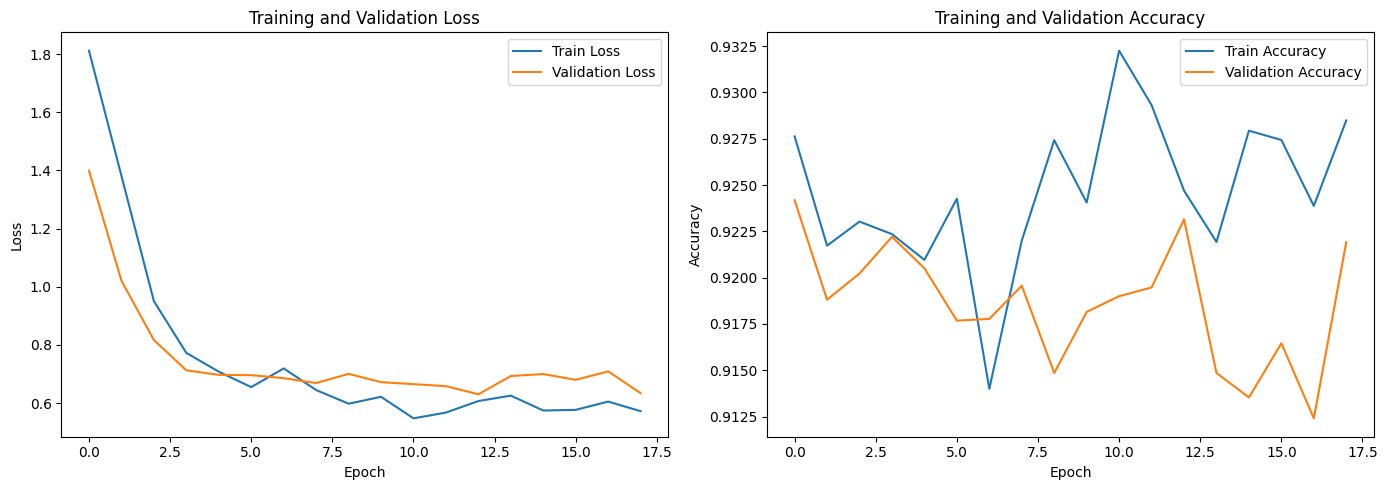

In [18]:
# Plot training history
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()

In [19]:
cedar_test_loss, cedar_test_acc = siamese_model.evaluate(test_dataset)
print(f"Test Loss: {cedar_test_loss:.4f}")
print(f"Test Accuracy: {cedar_test_acc:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 27s 6s/step - accuracy: 0.9085 - loss: 0.7434
Test Loss: 0.7407
Test Accuracy: 0.9088


In [20]:
(hindi_train_pairs, hindi_train_labels), (hindi_val_pairs, hindi_val_labels), (hindi_test_pairs, hindi_test_labels) = load_dataset(hindi_directory)

In [21]:
hindi_test_dataset = create_tf_dataset(hindi_test_pairs, hindi_test_labels)

In [22]:
hindi_test_loss, hindi_test_acc = siamese_model.evaluate(hindi_test_dataset)
print(f"Test Loss: {hindi_test_loss:.4f}")
print(f"Test Accuracy: {hindi_test_acc:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 70s 6s/step - accuracy: 0.9266 - loss: 0.6564
Test Loss: 0.6573
Test Accuracy: 0.9265


In [24]:
(bengali_train_pairs, bengali_train_labels), (bengali_val_pairs, bengali_val_labels), (bengali_test_pairs, bengali_test_labels) = load_dataset(bengali_directory)

In [25]:
binghali_test_dataset = create_tf_dataset(bengali_test_pairs, bengali_test_labels)

In [26]:
binghali_test_loss, binghali_test_acc = siamese_model.evaluate(binghali_test_dataset)
print(f"Test Loss: {binghali_test_loss:.4f}")
print(f"Test Accuracy: {binghali_test_acc:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 46s 6s/step - accuracy: 0.9192 - loss: 0.7885
Test Loss: 0.7881
Test Accuracy: 0.9193
